# Sectiunea 1 - Importarea bibliotecilor și definirea canalelor

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install wfdb
!pip install mne

import os
import matplotlib.pyplot as plt
#import pyedflib
import wfdb #WFDB (Waveform Database) package
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.8 MB/s eta 0:00:00


Channels of bipolar montage, there are used 18 out of 23:

In [10]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
           'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
           'FZ-CZ', 'CZ-PZ']

# Secțiunea 2 - Manipularea datelor

I extract the patients IDs

In [6]:
import glob
path = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)#the asterix * is for no brackets and commas

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


I randomise the patients and select the first 19 for training and last 5 for testing

In [7]:
import random
random.seed(17)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  01 04 05 06 07 08 09 10 11 12 14 15 16 17 18 19 21 22 24
Test PT:  02 03 13 20 23


Shows how many files are in total. (train, test)

In [8]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path+'/chb{}/*.edf'.format(l))
    
len(files_train), len(files_test)

(541, 145)

# Secțiunea 3 - Extragerea semnalelor și preprocesarea

In [ ]:
mne.set_log_level(verbose='ERROR') #show only error messages

## Secțiunea 3.1 - Extragerea semnalelor și atribuirea etichetelor 

In [ ]:
#creates a logging system information about processed files into a file called 'read_files.log'
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

#windows overlap 50%
time_window = 8 # 8-second time window
time_step = 4 # slides forward by 4 seconds

p = 0.01  
counter = 0 #how many eeg segments we have in total
#incarcam 
for temp_f in files_train: #temp_f = fisier .edf individual
    temp_edf =  mne.io.read_raw_edf(temp_f) #citeste fiserul edf si creeaza un obiect de tip raw
    temp_labels = temp_edf.ch_names # lista canalelor EEG
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels): #verifies if all channels exist
        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs #step-window cati pasi sunt intr-o fereastra de 8 secunde
        step = time_step*fs #cât "alunecă" fereastra (4 sec * 256 Hz = 1024 eșantioane)
        #temp_is_sz este un array de 0 și 1 care indică pentru fiecare eșantion dacă se află sau nu se află într-o criză. 
        temp_is_sz = np.zeros((temp_edf.n_times,)) #array cu val 0 pt tot semnalul
        
        #Marcheză porțiunile de semnal în care apar crizele, setând 1 în array-ul temp_is_sz, adica fisierele .edf.seizures
        if os.path.exists(temp_f+'.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1#Marchează cu 1 toate eșantioanele dintre început și sfârșit ca fiind în criză.
                
        #vector cu proportia de criza
        temp_len = temp_edf.n_times
        temp_is_sz_ind = np.array( #temp_is_sz_ind va avea valori între 0 și 1 (0 înseamnă nicio criză, 1 înseamnă criză 100% pe toată fereastra)
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]#cat intre 0 si 1 fereastra e in criza
        )

        #calculează câte segmente cu/și fără crize vor fi extrase
        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size
        counter = counter + temp_0_sample_size + temp_1_sample_size
    temp_edf.close()
    
#creez arrays dupa ce am calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf =  mne.io.read_raw_edf(temp_f)
    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
    if n_label_match==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6
        #marcheaza din nou crizele
        if os.path.exists(temp_f+'.seizures'):
            to_log = to_log+'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        else:
            to_log = to_log+'No sz.'

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))#T=intervalul de timp dintre 2 esantioane, apoi frecventa f=1/T de esantionare
        step_window = time_window*fs
        step = time_step*fs

        temp_is_sz_ind = np.array(
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
        )
        del temp_is_sz

        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

        # sz data
        temp_ind = list(np.where(temp_is_sz_ind>0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = True
            source_files.append(temp_f)
            counter = counter+1

        # no sz data
        temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = False
            source_files.append(temp_f)
            counter = counter+1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
            temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
        )

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
    
    logger.info(to_log)
    temp_edf.close()
#Curăță memoria RAM
    if n%10==0:
        gc.collect()
gc.collect()
# Salvează array-urile rezultate
np.save('/kaggle/working/signal_samples.npy', array_signals)
np.save('/kaggle/working/is_sz.npy', array_is_sz)
np.save('/kaggle/working/source_files.npy', np.array(source_files))

array_signals.shape #(num_windows, num_channels, window_length_samples)

In [9]:
import numpy as np

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals.shape)
print(array_is_sz.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

(9505, 18, 2048)
(9505,)
['/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf'
 '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf'
 '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf'
 '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf'
 '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf']
Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


In [ ]:
#incepand cu secundele 1,2,3 pentru toti copiii
!pip install wfdb

import logging
import random
import numpy as np
import mne
import wfdb
import os
import gc
import tqdm
import matplotlib.pyplot as plt

# Set up logging
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

# Window parameters
time_window = 8  # 8 seconds
fs = 256  # default sampling frequency
step_window = time_window * fs
p = 0.01

# Calculate total segments across all files
counter = 0
for temp_f in files_train:
    temp_edf = mne.io.read_raw_edf(temp_f)
    if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
        temp_len = temp_edf.n_times
        temp_is_sz = np.zeros(temp_len)
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(temp_annotation.sample.size // 2):
                temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
        # Include start offsets (0s, 1s, 2s, 3s)
        for offset in range(fs, 4 * fs, fs):
            temp_is_sz_ind = np.array([
                temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
                for i in range((temp_len - offset - step_window) // fs)
            ])
            counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
            counter += np.where(temp_is_sz_ind > 0)[0].size
    temp_edf.close()

del temp_is_sz

# Initialize arrays
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Extract and store segments
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    temp_edf = mne.io.read_raw_edf(temp_f)
    if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
        temp_len = temp_edf.n_times
        temp_is_sz = np.zeros(temp_len)
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(temp_annotation.sample.size // 2):
                temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
        for offset in range(0, 4 * fs, fs):
            temp_is_sz_ind = np.array([
                temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
                for i in range((temp_len - offset - step_window) // fs)
            ])
            
            # Extract seizure data
            temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
                array_is_sz[counter] = True
                source_files.append(temp_f)
                counter += 1
            
            # Extract non-seizure data
            temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
            temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
                array_is_sz[counter] = False
                source_files.append(temp_f)
                counter += 1
    temp_edf.close()
    if n % 10 == 0:
        gc.collect()

gc.collect()
np.save('/kaggle/working/signal_samples_2.npy', array_signals)
np.save('/kaggle/working/is_sz_2.npy', array_is_sz)
np.save('/kaggle/working/source_files.npy', np.array(source_files))

# Visualization of window distribution
signals = np.load('/kaggle/working/signal_samples_2.npy')
labels = np.load('/kaggle/working/is_sz_2.npy')
sources = np.load('/kaggle/working/source_files_2.npy')

print("Total number of windows:", signals.shape[0])
print("Number of seizure windows:", labels.sum())
print("Number of non-seizure windows:", len(labels) - labels.sum())

plt.figure(figsize=(10, 6))
plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
plt.title("Distribution of Seizure and Non-Seizure Windows")
plt.show()

In [10]:
import mne

# Verifică canalele disponibile în primul fișier chb02
temp_f = [f for f in files_train if "chb02_" in f][0]
raw = mne.io.read_raw_edf(temp_f, preload=False)
print(raw.ch_names)


Extracting EDF parameters from /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']


/tmp/ipykernel_31/1643667253.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(temp_f, preload=False)


In [ ]:
#incepand cu secundele 1,2,3 pentru chb_02
import logging
import random
import numpy as np
import mne
import wfdb
import os
import gc
import tqdm
import matplotlib.pyplot as plt

# Set up logging
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files_chb02.log')
logger.addHandler(fh)

# Window parameters
time_window = 8  # 8 seconds
fs = 256  # default sampling frequency
step_window = time_window * fs
p = 0.01

ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 
             'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 
             'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 
             'FT10-T8', 'T8-P8-1']

# Filter files for chb02 only
files_chb02 = [f for f in files_train if "chb02_" in f]

# Calculate total segments for chb02
counter = 0
for temp_f in files_chb02:
    temp_edf = mne.io.read_raw_edf(temp_f)
    if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
        temp_len = temp_edf.n_times
        temp_is_sz = np.zeros(temp_len)
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(temp_annotation.sample.size // 2):
                temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
        # Include start offsets (1s, 2s, 3s)
        for offset in [1 * fs, 2 * fs, 3 * fs]:
            temp_is_sz_ind = np.array([
                temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
                for i in range((temp_len - offset - step_window) // fs)
            ])
            counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
            counter += np.where(temp_is_sz_ind > 0)[0].size
    temp_edf.close()

del temp_is_sz

# Initialize arrays
array_signals_02 = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz_02 = np.zeros(counter, dtype=bool)
source_files = []

# Extract and store segments for chb02
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_chb02)):
    temp_edf = mne.io.read_raw_edf(temp_f)
    if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
        temp_len = temp_edf.n_times
        temp_is_sz = np.zeros(temp_len)
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(temp_annotation.sample.size // 2):
                temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
        # Include start offsets (1s, 2s, 3s)
        for offset in [1 * fs, 2 * fs, 3 * fs]:
            temp_is_sz_ind = np.array([
                temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
                for i in range((temp_len - offset - step_window) // fs)
            ])
            
            # Extract seizure data
            temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
            for i in temp_ind:
                array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
                array_is_sz_02[counter] = True
                source_files.append(temp_f)
                counter += 1
            
            # Extract non-seizure data
            temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
            temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
                array_is_sz_02[counter] = False
                source_files.append(temp_f)
                counter += 1
    temp_edf.close()
    if n % 10 == 0:
        gc.collect()

gc.collect()
np.save('/kaggle/working/signal_samples_chb02.npy', array_signals)
np.save('/kaggle/working/is_sz_chb02.npy', array_is_sz)
np.save('/kaggle/working/source_files_chb02.npy', np.array(source_files))

# Visualization of window distribution
signals = np.load('/kaggle/working/signal_samples_chb02.npy')
labels = np.load('/kaggle/working/is_sz_chb02.npy')
sources = np.load('/kaggle/working/source_files_chb02.npy')

print("Total number of windows (chb02):", signals.shape[0])
print("Number of seizure windows (chb02):", labels.sum())
print("Number of non-seizure windows (chb02):", len(labels) - labels.sum())

plt.figure(figsize=(10, 6))
plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
plt.title("Distribution of Seizure and Non-Seizure Windows (chb02)")
plt.show()

In [11]:
#random seed 2023
import numpy as np

array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

In [12]:
array_signals.shape

(9505, 18, 2048)

In [13]:
array_is_sz.shape

(9505,)

In [14]:
source_files.shape

(9505,)

## Secțiunea 3.2 - Preprocesarea 

### Secțiunea 3.2.1. Graphics: Samples of extracted signals

In [ ]:
# show a sample of extracted signals, one plot, the first two and the last two

import matplotlib.pyplot as plt
vertical_width = 250
#----------------------------------------------------------
#frecventa 2048
signals = array_signals[1, :, :]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#---------------------------frecventa 1024
signals = array_signals[1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-----------------------------primele 3 canale
signals = array_signals[1, :3, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(15, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[-2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#----------------------------------------------------------
signals = array_signals[-1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Samples with seizures. Two plots, with heatmaps
import random
import os

for n in random.sample(list(array_n), 10):
    temp_signals = array_signals[n, :, :]
    fs = 128
    vertical_width = 300
    file_origin = source_files[n]
    file_short = os.path.basename(file_origin)

    #creeaza grafic cu 2 sub-grafice
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    
    # Subgraficul 0 - semnal EEG (multi-canal)
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1]) / fs,
                   temp_signals[i, :] + i * vertical_width,
                   linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i * vertical_width))
    
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title(f'Sample no. {n} | Source: {file_short}')

    # Subgraficul 1 - heatmap
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1]) / fs,
                     np.arange(len(ch_labels)),
                     temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [6]:
#random seed 17
import numpy as np

array_signals = np.load('/kaggle/input/eeg-processed-samples/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-processed-samples/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-processed-samples/source_files.npy', allow_pickle=True)

In [1]:
#random seed 2023
import numpy as np

array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

### 3.2.2. Channel dimension and data split

In [7]:
array_signals = array_signals[:, :, ::2]
array_signals.shape

(10048, 18, 1024)

In [8]:
# CNN will be used. Channel dimension is added.

array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(10048, 18, 1024, 1)

In [10]:
#Split data
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Împărțim datele: 80% pentru antrenare, 20% pentru testare
X_train, X_test, y_train, y_test = train_test_split(
    array_signals,        # semnalele EEG
    array_is_sz,          # etichetele (True = criză, False = non-criză)
    test_size=0.2,        # 20% din date merg în setul de test
    random_state=42,      # pentru reproductibilitate
    stratify=array_is_sz  # păstrează proporția dintre clase (criză/non-criză)
)
print("Dimensiuni X_train:", X_train.shape)
print("Dimensiuni y_train:", y_train.shape)
print("Dimensiuni X_test:", X_test.shape)
print("Dimensiuni y_test:", y_test.shape)

# # Adăugăm expand_dim pentru CNN 2D
# X_train = np.expand_dims(X_train, axis=-1)  # (8038, 18, 2048, 1)
# X_test = np.expand_dims(X_test, axis=-1)    # (2010, 18, 2048, 1)

# # Normalizare între 0 și 1
# X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
# X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

# print("Dimensiuni actualizate X_train:", X_train.shape)
# print("Dimensiuni actualizate y_train:", y_train.shape)
# print("Dimensiuni actualizate X_test:", X_test.shape)
# print("Dimensiuni actualizate y_test:", y_test.shape)

# Funcție pentru afișarea distribuției etichetelor
def show_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"\nDistribuție {name}:")
    for val, cnt in zip(unique, counts):
        pct = 100 * cnt / total
        label = "criză" if val == 1 else "non-criză"
        print(f"  {label} ({val}): {cnt} ({pct:.2f}%)")

# Afișarea distribuției
show_distribution(y_train, "y_train")
show_distribution(y_test, "y_test")

from sklearn.utils.class_weight import compute_class_weight


# Calculăm ponderile pentru clase
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: w for i, w in zip(classes, class_weights)}

print("\nPonderi clase:", class_weights)


Dimensiuni X_train: (8038, 18, 1024, 1)
Dimensiuni y_train: (8038,)
Dimensiuni X_test: (2010, 18, 1024, 1)
Dimensiuni y_test: (2010,)

Distribuție y_train:
  non-criză (False): 5888 (73.25%)
  criză (True): 2150 (26.75%)

Distribuție y_test:
  non-criză (False): 1472 (73.23%)
  criză (True): 538 (26.77%)

Ponderi clase: {False: 0.6825747282608695, True: 1.8693023255813954}


# Secțiunea 4 - Antrenarea modelului de învațare automata utilizând CNN 2D

In [ ]:
#veirifes if there is a GPU
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

## Secțiunea 4.1 - Rețea neuronală convoluțională (CNN) în Keras/TensorFlow, destinată clasificării binare

2025-05-16 11:43:59.299993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747395839.524677      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747395839.587785      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-16 11:44:12.471238: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 18, 1024, 64)        │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 512, 64)         │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 256, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 256, 128)        │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 128, 128)        │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 64, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 64, 256)          │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 32, 256)          │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 16, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,910,657 (7.29 MB)

 Trainable params: 1,910,657 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

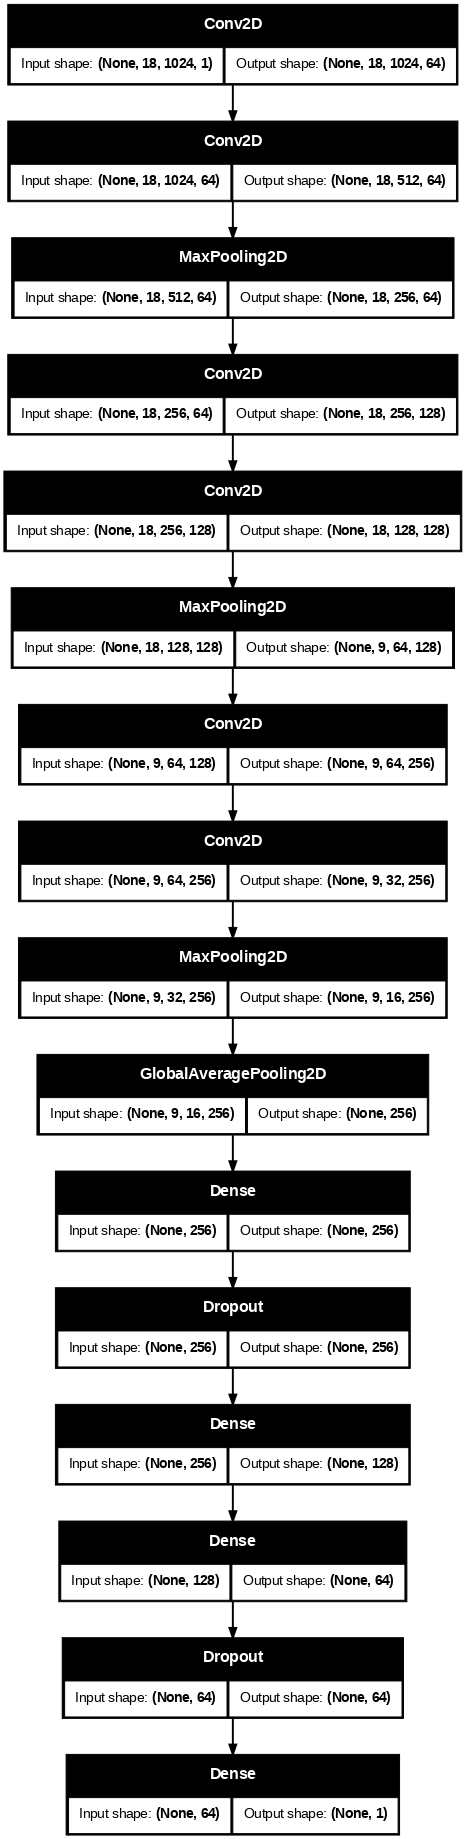

In [11]:
import tensorflow as tf  # Importă biblioteca TensorFlow pentru machine learning și deep learning
from tensorflow import keras  # Importă modulul keras din TensorFlow, o interfață simplificată pentru rețele neuronale
from tensorflow.keras import layers  # Importă modulul pentru definirea straturilor rețelei neuronale (Dense, Conv2D etc.)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  
# callback1: ReduceLROnPlateau scade rata de învățare dacă performanța stagnează
# callback2: EarlyStopping oprește antrenamentul dacă nu mai există îmbunătățiri (pentru a evita overfitting-ul)


## deep learning model
model = keras.models.Sequential() #creez modelul secvențial, strat cu strat

#filters=filtrele
#kernel_size=(A,B): filtrele sunt de A canale pe B eșantioane
#layers.Conv2D - convolutie
#pooling - operație de reducere a dimensiunii datelor pastrand cele mai importante caracteristici

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

#-------------------------------------------------------------------------------
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

In [12]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8038, 18, 1024, 1), (8038,), (2010, 18, 1024, 1), (2010,))

## Secțiunea 4.2 - Antrenarea modelului

In [ ]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=256,
    callbacks=callbacks
)

In [ ]:
import pandas as pd

# Creez un DataFrame din istoricul antrenării
history_df = pd.DataFrame(hist.history)

# Salvez ca fișier CSV
history_df.to_csv('training_history.csv', index=False)

history_df.head()

In [ ]:
model.save('CHB_MIT_sz_detec.h5')

## Secțiunea 4.3 - Grafice pentru evoluția pierderii și acuratețe

In [ ]:
#imediat dupa antrenare
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


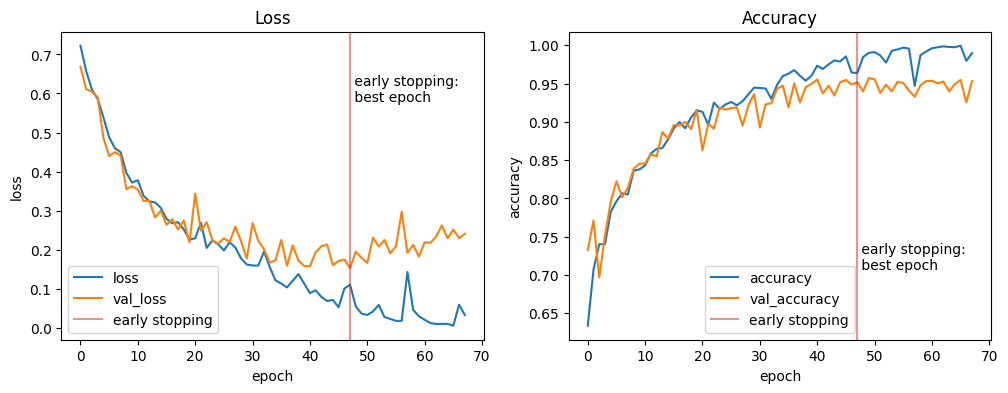

In [14]:
#preia antrenarea din memorie
import pandas as pd
import matplotlib.pyplot as plt

# Încarcă istoricul din fișierul CSV
df = pd.read_csv('/kaggle/input/model-history-training/training_history.csv')

# Adăugăm o coloană 'epoch' care reprezintă indicele fiecărui rând
df['epoch'] = df.index

# Creăm un dicționar cu valorile necesare pentru plot
hist = {
    'loss': df['loss'].values,
    'val_loss': df['val_loss'].values,
    'accuracy': df['accuracy'].values,
    'val_accuracy': df['val_accuracy'].values
}

# Configurare plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot pentru Loss
ax[0].plot(hist['loss'], label='loss')
ax[0].plot(hist['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
es_best_epoch = df['val_loss'].idxmin()  # Epoca cu valoarea minimă pentru 'val_loss'
ax[0].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist['loss'])+(1-r)*max(hist['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

# Plot pentru Accuracy
ax[1].plot(hist['accuracy'], label='accuracy')
ax[1].plot(hist['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
r = .8
temp_y = r*min(hist['accuracy'])+(1-r)*max(hist['accuracy'])
ax[1].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


In [13]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_seizure_model/tensorflow2/default/1/CHB_MIT_sz_detec.h5')

2025-05-16 11:49:55.366912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747396195.547037      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747396195.600441      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747396207.067969      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747396207.068703      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

# Secțiunea 5 - Evaluarea Modelului

In [16]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [11]:
mne.set_log_level(verbose='ERROR') #show only error messages

In [14]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

  0%|          | 0/145 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1747396253.140532     109 service.cc:148] XLA service 0x784e90002790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747396253.141248     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747396253.141267     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747396253.246282     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747396256.365494     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 145/145 [05:06<00:00,  2.11s/it]


Arata fisierul si predictiile

In [ ]:
# import numpy as np
# import pandas as pd

# # Aplatizează predicțiile și etichetele într-un singur array
# y_pred_all = np.concatenate(list_pred)
# y_true_all = np.concatenate(list_true)

# # Aplatizare în cazul în care predicțiile sunt în format coloană
# if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
#     y_pred_all = y_pred_all.flatten()

# # Creează DataFrame cu primele 30 de exemple
# df = pd.DataFrame({
#     'Predicted': y_pred_all[:50000],
#     'Actual': y_true_all[:50000]
# })

# # Adaugă eticheta binară (0 sau 1) pe baza unui prag de 0.5
# df['Predicted_Label'] = (df['Predicted'] >= 0.5).astype(int)

# # Salvează tabelul într-un fișier CSV
# df.to_csv('model_predictions_sample.csv', index=False)

# # Confirmare
# print("Fișierul 'model_predictions_sample.csv' a fost salvat.")
#-------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Aplatizează predicțiile și etichetele
y_pred_all = np.concatenate(list_pred)
y_true_all = np.concatenate(list_true)

# Aplatizare dacă e necesar
if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
    y_pred_all = y_pred_all.flatten()

# Creează DataFrame complet
df_all = pd.DataFrame({
    'Predicted': y_pred_all,
    'Actual': y_true_all
})

# Filtrare: doar segmente cu criză reală
df_sz_only = df_all[df_all['Actual'] > 0]

# Adaugă eticheta binară de predicție
df_sz_only['Predicted_Label'] = (df_sz_only['Predicted'] >= 0.5).astype(int)

# Salvează fișierul CSV
df_sz_only.to_csv('model_predictions_only_seizures.csv', index=False)

print("Fișierul 'model_predictions_only_seizures.csv' a fost salvat.")


In [23]:
print("Număr total segmente cu crize:", np.sum(y_true_all > 0))

Număr total segmente cu crize: 522


## Secțiunea 5.1 - Precision, Recall, F1-score

In [22]:
print(f"Număr total de crize (în etichetele reale): {np.sum(y_true_all)}")

Număr total de crize (în etichetele reale): 456.75


In [24]:
print(f"Dimensiune y_true_all: {y_true_all.shape}")
print(f"Dimensiune y_pred_all: {y_pred_all.shape}")

Dimensiune y_true_all: (144089,)
Dimensiune y_pred_all: (144089,)


In [25]:
print("Valori unice în y_true_all:", np.unique(y_true_all))
print("Dimensiune y_true_all:", y_true_all.shape)
print("Suma elementelor:", np.sum(y_true_all))


Valori unice în y_true_all: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
Dimensiune y_true_all: (144089,)
Suma elementelor: 456.75


In [18]:
from sklearn import metrics

# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

# threshold = 0.4
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.4)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    143567
        True       0.13      0.48      0.21       522

    accuracy                           0.99    144089
   macro avg       0.57      0.74      0.60    144089
weighted avg       0.99      0.99      0.99    144089

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    143567
        True       0.29      0.35      0.32       522

    accuracy                           0.99    144089
   macro avg       0.64      0.68      0.66    144089
weighted avg       1.00      0.99      0.99    144089

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    143567
        True       0.11      0.50      0.18       522

    accuracy                           0.98    144089
   macro avg       0.55      0.74      0.59    144089
weighted avg       0.99      0.98      0.99    144089



## Secțiunea 5.2 - Curba ROC

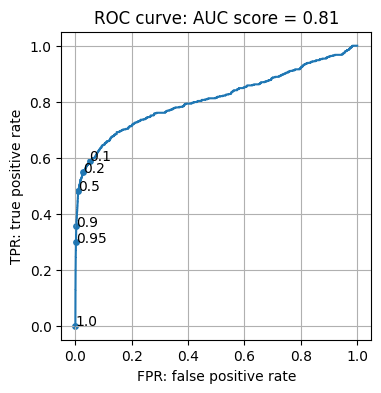

In [19]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

## Secțiunea 5.3 - Matricea de confuzie

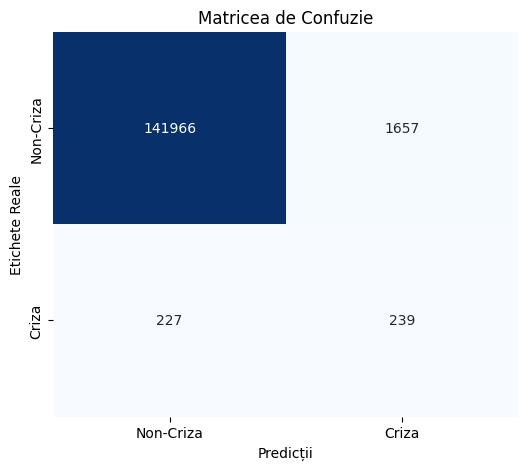

Număr de non-crize reale (TN): 141966
Număr de crize reale (TP): 239
Număr de non-crize prezise greșit (FP): 1657
Număr de crize prezise greșit (FN): 227

Explicație:
Din totalul crizelor reale (466), modelul a prezis corect 239 crize și a prezis greșit 227.
Din totalul non-crizelor reale (143623), modelul a prezis corect 141966 non-crize și a prezis greșit 1657.


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_all = np.concatenate(list_pred)
y_true_all = np.concatenate(list_true)

if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
    y_pred_all = y_pred_all.flatten()

y_pred_labels = (y_pred_all >= 0.5).astype(int)
y_true_labels = (y_true_all >= 0.5).astype(int)

cm = confusion_matrix(y_true_labels, y_pred_labels)

cm_df = pd.DataFrame(cm, index=["Non-Criza", "Criza"], columns=["Non-Criza", "Criza"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matricea de Confuzie")
plt.xlabel("Predicții")
plt.ylabel("Etichete Reale")
plt.show()

TN, FP, FN, TP = cm.ravel()

print(f"Număr de non-crize reale (TN): {TN}")
print(f"Număr de crize reale (TP): {TP}")
print(f"Număr de non-crize prezise greșit (FP): {FP}")
print(f"Număr de crize prezise greșit (FN): {FN}")

print("\nExplicație:")
print(f"Din totalul crizelor reale ({TP + FN}), modelul a prezis corect {TP} crize și a prezis greșit {FN}.")
print(f"Din totalul non-crizelor reale ({TN + FP}), modelul a prezis corect {TN} non-crize și a prezis greșit {FP}.")


## Secțiunea 5.4 - Seizure detection point

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

In [ ]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n
    
    return temp


# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

In [ ]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

In [ ]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()

# NOT USEFULL YET

**HEATMAPS**  **training part**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # pentru bara de progres

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)


In [ ]:
import zipfile
import os

# Setează calea către folderul care conține imaginile
folder_path = '/kaggle/working/heatmaps/train'

# Numele fișierului zip
zip_file = '/kaggle/working/heatmaps_train.zip'

# Creează un fișier zip
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Parcurge folderele din directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Adaugă fiecare fișier .png la arhivă
            if file.endswith('.png'):
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

print(f'Fișierul zip a fost creat la {zip_file}')

import shutil

# Muta arhiva într-un loc accesibil pentru download
shutil.move(zip_file, '/kaggle/working/heatmaps_train.zip')

# Link de descărcare
from IPython.display import FileLink

# Crează un link de descărcare
FileLink(r'/kaggle/working/heatmaps_train.zip')

In [ ]:
import pandas as pd
import os

image_paths = []
labels = []

base_path = '/kaggle/working/heatmaps/train'

for label in ['criza', 'non_criza']:
    full_path = os.path.join(base_path, label)
    for fname in os.listdir(full_path):
        if fname.endswith('.png'):
            image_paths.append(os.path.join(full_path, fname))
            labels.append(label)

train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("CSV-ul a fost creat pe baza imaginilor existente.")


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Creăm o listă pentru căile fișierelor și etichetele corespunzătoare
image_paths = []
labels = []

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)
    
    # Adăugăm calea fișierului și eticheta în liste
    image_paths.append(save_path)
    labels.append(label)

# Creăm un DataFrame din listele de căi și etichete
train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Salvăm DataFrame-ul ca fișier CSV
train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("Dataset-ul pentru train a fost salvat ca fișier CSV.")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from tqdm import tqdm  # pentru bara de progres

# # Creează foldere pentru imagini
# os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/non_criza', exist_ok=True)

# # Funcție care salvează heatmap-ul
# def save_heatmap(signal, path):
#     plt.figure(figsize=(4, 4))
#     plt.axis('off')
#     plt.pcolormesh(signal, cmap='gray')  # poți schimba cmap dacă vrei alt efect
#     plt.gca().invert_yaxis()
#     plt.tight_layout(pad=0)
#     plt.savefig(path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# # Salvează imaginile de antrenare
# for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
#     label = 'criza' if y_train[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
#     save_heatmap(X_train[idx, :, :], save_path)

# # Salvează imaginile de testare
# for idx in tqdm(range(X_test.shape[0]), desc="Generăm heatmap-uri pentru test"):
#     label = 'criza' if y_test[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/test/{label}/{idx}.png'
#     save_heatmap(X_test[idx, :, :], save_path)


In [ ]:
#DE LA CHAT GPT 
#from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam

# # Definirea modelului
# model = Sequential()

# # 1. Primul strat convoluțional
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(18, 2048, 1)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

# # 2. Al doilea strat convoluțional
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

# # 3. Al treilea strat convoluțional
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))

# # 4. Flatten + Dense layers
# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# # 5. Stratul final - clasificare binară
# model.add(Dense(1, activation='sigmoid'))

# # Compilarea modelului
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Rezumat model
# model.summary()
